In [5]:
from datetime import datetime
import math
import soccerdata as sd
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import re
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning)

In [84]:
class Club:
    def __init__(self, name, elo_rating, date=None):
        self.name = name
        self.elo_rating = elo_rating
        self.history = {date or datetime.now(): elo_rating}

    def update_elo_rating(self, new_rating, date):
        self.elo_rating = new_rating
        self.history[date] = new_rating

class Match:
    def __init__(self, home_club, away_club, home_goals, away_goals, date):
        self.home_club = home_club
        self.away_club = away_club
        self.home_goals = home_goals
        self.away_goals = away_goals
        self.date = date
        self.result = self.calculate_result()

    def calculate_result(self):
        if self.home_goals > self.away_goals:
            return 1
        elif self.home_goals < self.away_goals:
            return 0
        else:
            return 0.5

    def calculate_elo_ratings(self, k=25, HFA=100):
        dr = self.home_club.elo_rating - self.away_club.elo_rating + HFA
        E = 1 / (10**(-dr/400) + 1)
        ΔElo_1X2 = (self.result - E) * k
        margin = abs(self.home_goals - self.away_goals)
        ΔElo_margin = ΔElo_1X2 * math.sqrt(margin)
        self.home_club.update_elo_rating(self.home_club.elo_rating + ΔElo_margin, self.date)
        self.away_club.update_elo_rating(self.away_club.elo_rating - ΔElo_margin, self.date)

In [30]:
fbref= sd.FBref(leagues="USA-Major League Soccer", seasons=[x for x in range(2015,2025)])

mls_schedule_fbref = fbref.read_schedule()


mls_schedule_fbref=mls_schedule_fbref.drop(columns=["round","day","time","home_xg","away_xg","attendance","venue","referee","match_report","notes","game_id"])
mls_schedule_fbref[['home_goals', 'away_goals']] = mls_schedule_fbref['score'].str.split('–', expand=True)
mls_schedule_fbref['home_goals'] = mls_schedule_fbref['home_goals'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
mls_schedule_fbref['home_goals'] = pd.to_numeric(mls_schedule_fbref['home_goals'])
mls_schedule_fbref['away_goals'] = mls_schedule_fbref['away_goals'].fillna('').apply(lambda x: sum(int(num) for num in re.findall(r'\d+', x)))
mls_schedule_fbref['away_goals'] = pd.to_numeric(mls_schedule_fbref['away_goals'])
mls_schedule_fbref['date'] = pd.to_datetime(mls_schedule_fbref['date'])
mls_schedule_fbref = mls_schedule_fbref.sort_values(by='date')
mls_schedule_fbref = mls_schedule_fbref.drop(columns=["score"])


#print(mls_schedule_fbref.info()) #information about the data
#print(mls_schedule_fbref.columns) #column names
#print(mls_schedule_fbref.describe()) #summary of the data
#print(mls_schedule_fbref.shape)   #dimension of the data
#mls_schedule_fbref.iloc[450:460]
mls_schedule_fbref.head()

[06/18/24 11:14:13] INFO     Saving cached data to /Users/gabrielmasella/soccerdata/data/FBref        _common.py:92

date  \
league                  season game                                                 
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire       2015-03-06   
                               2015-03-07 D.C. United-CF Montréal      2015-03-07   
                               2015-03-07 FC Dallas-SJ Earthquakes     2015-03-07   
                               2015-03-07 Houston Dynamo-Colombus Crew 2015-03-07   
                               2015-03-07 Philadelphia-Colorado Rapids 2015-03-07   

                                                                             home_team  \
league                  season game                                                      
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire             LA Galaxy   
                               2015-03-07 D.C. United-CF Montréal          D.C. United   
                               2015-03-07 FC Dallas-SJ Earthquakes           FC Dallas   
                               2015-03-07 Houston Dynamo-Colombus Crew  Houston Dynamo   
                               2015-03-07 Philadelphia-Colorado Rapids    Philadelphia   

                                                                              away_team  \
league                  season game                                                       
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire           Chicago Fire   
                               2015-03-07 D.C. United-CF Montréal           CF Montréal   
                               2015-03-07 FC Dallas-SJ Earthquakes       SJ Earthquakes   
                               2015-03-07 Houston Dynamo-Colombus Crew    Colombus Crew   
                               2015-03-07 Philadelphia-Colorado Rapids  Colorado Rapids   

                                                                        week  \
league                  season game                                            
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire        <NA>   
                               2015-03-07 D.C. United-CF Montréal       <NA>   
                               2015-03-07 FC Dallas-SJ Earthquakes      <NA>   
                               2015-03-07 Houston Dynamo-Colombus Crew  <NA>   
                               2015-03-07 Philadelphia-Colorado Rapids  <NA>   

                                                                        home_goals  \
league                  season game                                                  
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire                 2   
                               2015-03-07 D.C. United-CF Montréal                1   
                               2015-03-07 FC Dallas-SJ Earthquakes               1   
                               2015-03-07 Houston Dynamo-Colombus Crew           1   
                               2015-03-07 Philadelphia-Colorado Rapids           0   

                                                                        away_goals  
league                  season game                                                 
USA-Major League Soccer 1516   2015-03-06 LA Galaxy-Chicago Fire                 0  
                               2015-03-07 D.C. United-CF Montréal                0  
                               2015-03-07 FC Dallas-SJ Earthquakes               0  
                               2015-03-07 Houston Dynamo-Colombus Crew           0  
                               2015-03-07 Philadelphia-Colorado Rapids           0

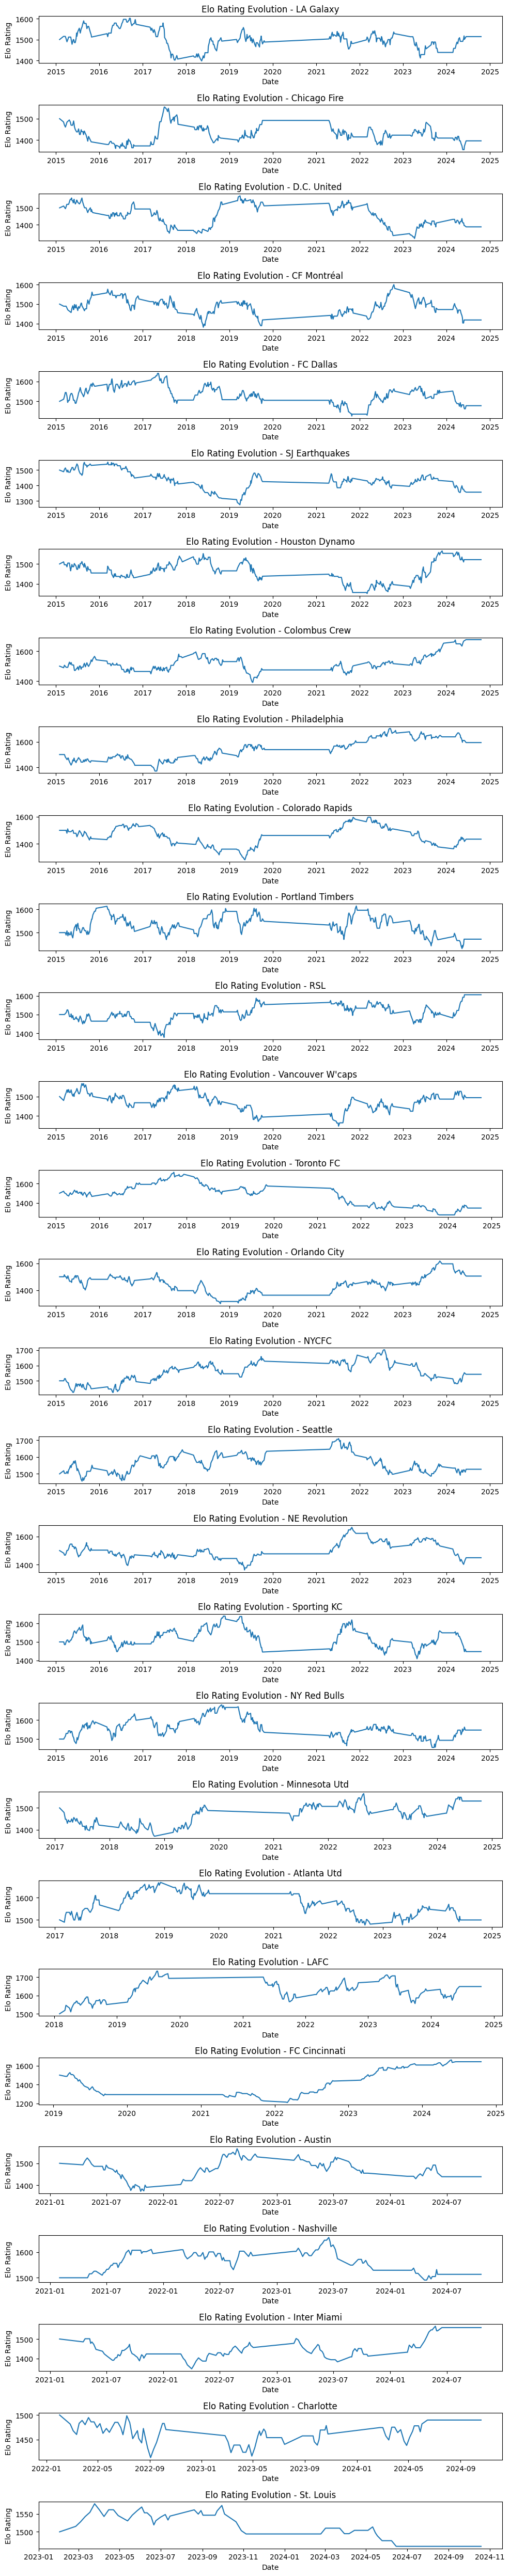

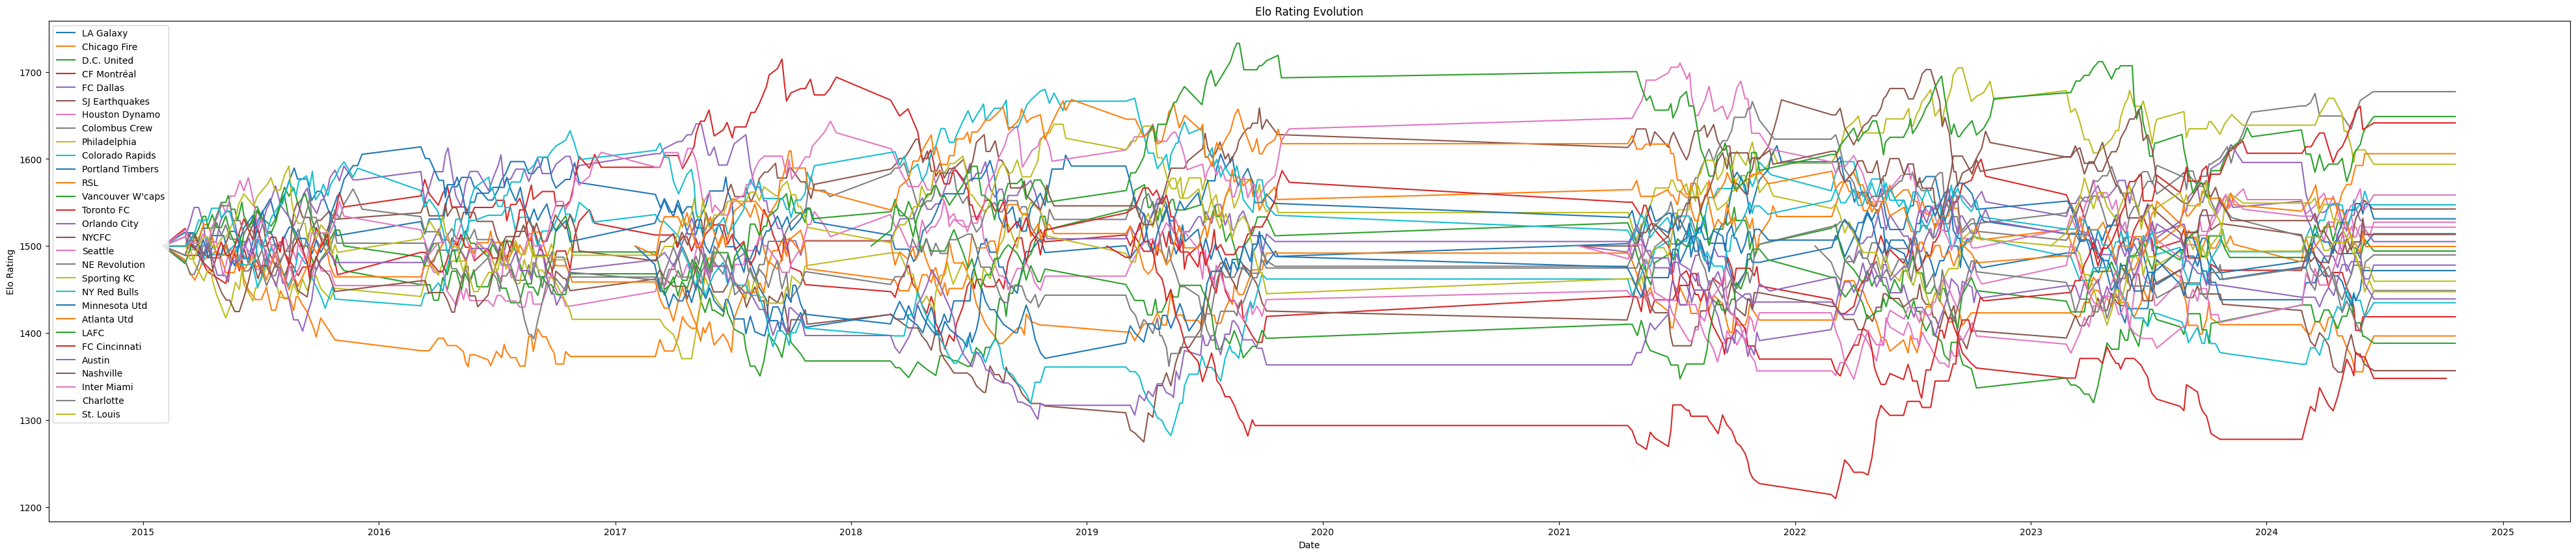

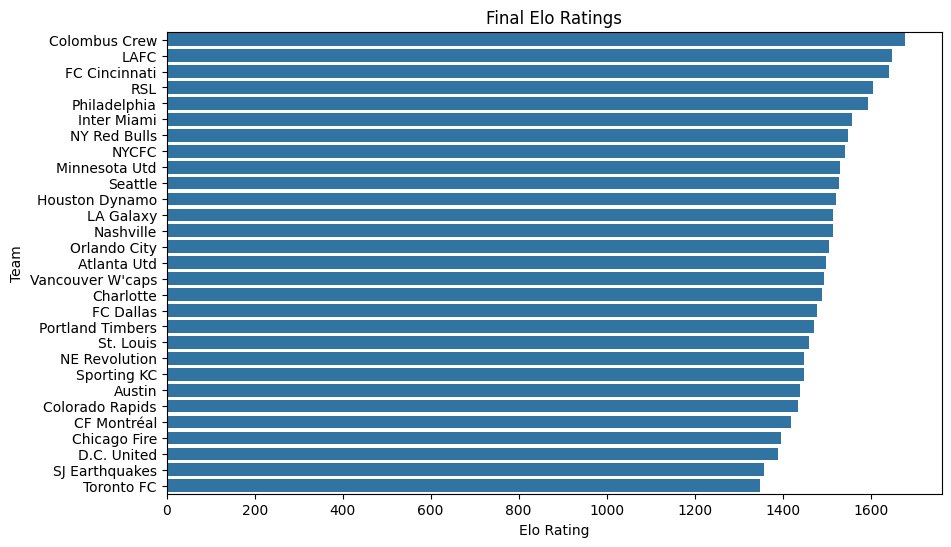

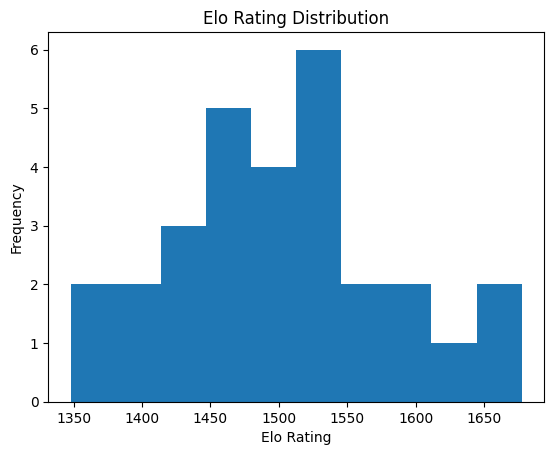

In [86]:
elo_ratings = {}  # Step 1 - Initialize dictionary to store Elo ratings

# Step 2 - Iterate over each match in the schedule
for _, match in mls_schedule_fbref.iterrows():
    home_team = match['home_team']
    away_team = match['away_team']
    home_goals = match['home_goals']
    away_goals = match['away_goals']
    date = match['date']
    
    if home_team not in elo_ratings:  # Step 4 - Initialize Elo ratings for new clubs
        elo_ratings[home_team] = Club(home_team, 1500, pd.Timestamp(f'{date.year}-02-01'))
    if away_team not in elo_ratings:
        elo_ratings[away_team] = Club(away_team, 1500, pd.Timestamp(f'{date.year}-02-01'))

    current_match = Match(elo_ratings[home_team], elo_ratings[away_team], home_goals, away_goals, date)
    current_match.calculate_elo_ratings(HFA=50)
    
    # Step 2.1 - Update Elo ratings for each club
    elo_ratings[home_team].update_elo_rating(current_match.home_club.elo_rating, date)
    elo_ratings[away_team].update_elo_rating(current_match.away_club.elo_rating, date)

# Step 3 - Plot Elo rating evolution for each club in each canvas
fig, axs = plt.subplots(len(elo_ratings.items()), 1, figsize=(10, 50))
for i, (team, club) in enumerate(elo_ratings.items()):
    axs[i].plot(list(club.history.keys()), list(club.history.values()))
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Elo Rating')
    axs[i].set_title(f'Elo Rating Evolution - {team}')
plt.tight_layout()
plt.show()

# Step 3 - Plot Elo rating evolution for each club in a single canvas
fig, ax = plt.subplots(figsize=(50, 10))
for team, club in elo_ratings.items():
    ax.plot(list(club.history.keys()), list(club.history.values()), label=team)
ax.set_xlabel('Date')
ax.set_ylabel('Elo Rating')
ax.set_title('Elo Rating Evolution')
ax.legend()
plt.show()


# Step 4 - Print final Elo ratings sorted by elo
sorted_elo_ratings = sorted(elo_ratings.items(), key=lambda x: x[1].elo_rating, reverse=True)
#for team, club in sorted_elo_ratings:
#    print(f'{team}: {club.elo_rating}')

# Step 5 - Visualize final Elo ratings
teams = [team for team, _ in sorted_elo_ratings]
ratings = [club.elo_rating for _, club in sorted_elo_ratings]

plt.figure(figsize=(10, 6))
sns.barplot(x=ratings, y=teams)
plt.xlabel('Elo Rating')
plt.ylabel('Team')
plt.title('Final Elo Ratings')
plt.show()


# Step 6 Histogram of Elo ratings
elo_ratings_values = [club.elo_rating for club in elo_ratings.values()]
plt.hist(elo_ratings_values, bins=10)
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.title('Elo Rating Distribution')
plt.show()


In [92]:
# Step 7.2 - Export Elo rating evolution to CSV from 2019
elo_history = []
for club in elo_ratings.values():
    for date, ratings in club.history.items():
        if date.year >= 2018:
            elo_history.append({'Club': club.name, 'Date': date, 'Elo Rating': ratings})
elo_history = pd.DataFrame(elo_history)
elo_history.to_csv('mls_elo_history.csv', index=False)